<a href="https://colab.research.google.com/github/guillermocalderon2021/tfm-words-embeddings/blob/main/EDOS1_ModelosClasicosipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargando dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/edos/')

import pandas as pd
df = pd.read_csv("edos_labelled_aggregated.csv")
df.head()

Mounted at /content/drive


,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df_syn = pd.read_csv("edos_aug_eda.csv")
#df_syn = df_syn.drop(columns=['__index_level_0__'])
df_syn.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"rape Nigeria, if you In a woman, the you back!...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a 😉 keeper.",not sexist,none,none,train
2,sexism2022_english-13149,"This is again, Metallica video where the poor ...",not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I a she wished she had bet gun,not sexist,none,none,dev


In [ ]:
df_train_original = df[df['split']=='train']
df_dev = df[df['split']=='dev']
df_test = df[df['split']=='test']

In [ ]:
df_train = pd.concat([df_train_original, df_syn[(df_syn['split'] == 'train') & (df_syn['label_sexist'] == 'sexist')]])
#df_train = pd.concat([df_train_original])
print(df_train_original.shape)
print(df_train.shape)

(14000, 6)
(17398, 6)


In [ ]:

X_train = df_train['text'].fillna('')
X_val = df_dev['text'].fillna('')
X_test= df_test['text'].fillna('')

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
X_train = X_train.apply(preprocess)
X_val = X_val.apply(preprocess)
X_test = X_test.apply(preprocess)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Inicializa el codificador de etiquetas
label_encoder = LabelEncoder()

# Ajusta el codificador y transforma las etiquetas de texto a números
y_train_num = label_encoder.fit_transform(df_train['label_sexist'])
y_val_num = label_encoder.transform(df_dev['label_sexist'])
y_test_num = label_encoder.transform(df_test['label_sexist'])
# Obtener los nombres de las etiquetas
label_names = label_encoder.inverse_transform(range(len(set(y_train_num))))
print(y_test_num)


[0 1 0 ... 0 0 1]


# Frecuencias

In [ ]:
# Frecuencias
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectors_train = vectorizer.fit_transform(X_train)
vectors_val = vectorizer.transform(X_val)
vectors_test = vectorizer.transform(X_test)


In [ ]:
# Para validación cruzada
from scipy.sparse import vstack
import numpy as np

vectors_train = vstack([vectors_train, vectors_val])


In [ ]:
y_train_num=np.concatenate((y_train_num,y_val_num))

## TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(X_train)
vectors_val = vectorizer.transform(X_val)
vectors_test = vectorizer.transform(X_test)

In [ ]:
# Para validación cruzada
from scipy.sparse import vstack
import numpy as np

vectors_train = vstack([vectors_train, vectors_val])
y_train_num=np.concatenate((y_train_num,y_val_num))

# Embedding estaticos

In [ ]:
def vectorize_text(text, model):
    vectors = [model[word] for word in text.split() if word in model]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(vectors, axis=0)

In [ ]:
import gensim.downloader
# Show all available models in gensim-data
models=['fasttext-wiki-news-subwords-300',  'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100',
        'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load(''word2vec-google-news-300')

# Use the downloaded vectors as usual:
glove_vectors.most_similar('twitter')
[('facebook', 0.948005199432373),
 ('tweet', 0.9403423070907593),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104824066162109),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885937333106995),
 ('tweets', 0.8878158330917358),
 ('tl', 0.8778461217880249),
 ('link', 0.8778210878372192),
 ('internet', 0.8753897547721863)]

In [ ]:
import gensim.downloader
word2_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')
#embeddings_path = '/content/drive/My Drive/Embeddings/word2vec-google-news-300.bin.gz'
#word2_vectors.save_word2vec_format(embeddings_path, binary=True)

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
import numpy as np
vectors_train = np.array([vectorize_text(text, word2_vectors) for text in X_train])
vectors_val = np.array([vectorize_text(text, word2_vectors) for text in X_val])
vectors_test = np.array([vectorize_text(text, word2_vectors) for text in X_test])

In [ ]:
vocab_size=len(word2_vectors.key_to_index)
print(vocab_size)

400000


In [ ]:
# Para validacion cruzada
vectors_train=np.concatenate((vectors_train,vectors_val))


In [ ]:
y_train_num=np.concatenate((y_train_num,y_val_num))

# Entrenando embeddings

In [ ]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=5, workers=4)

In [ ]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
vectors_train = np.array([vectorize(sentence) for sentence in X_train])
vectors_val = np.array([vectorize(sentence) for sentence in X_val])
vectors_test = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
# Para validacion cruzada
vectors_train=np.concatenate((vectors_train,vectors_val))

In [ ]:
y_train_num=np.concatenate((y_train_num,y_val_num))

# SVM

In [ ]:
print(vectors_train.shape)
print(y_train_num.shape)


(19398, 200)
(19398,)


In [ ]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Definir el clasificador SVM
svm_clf = SVC()

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Realizar la búsqueda en grilla con validación cruzada
grid_search = HalvingGridSearchCV(svm_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
grid_search.fit(vectors_train, y_train_num)

# Obtener el mejor clasificador
best_svm_clf = grid_search.best_estimator_


# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = best_svm_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test_num, y_test_pred,target_names=label_names))
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 718
max_resources_: 19398
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 718
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.621, test=0.640) total time=   0.1s
[CV 2/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.636, test=0.636) total time=   0.0s
[CV 3/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.590, test=0.623) total time=   0.1s
[CV 1/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.621, test=0.640) total time=   0.0s
[CV 2/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.636, test=0.636) total time=   0.0s
[CV 3/3] END C=0.1, gamma=1, kernel=linear;, score=(train=0.590, test=0.623) total time=   0.0s
[CV 1/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.621, test=0.640) total time=   0.1s
[CV 2/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.636, test=0.636) 

In [ ]:
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test_num, y_test_pred,target_names=label_names))
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

Métricas en el conjunto de prueba:
              precision    recall  f1-score   support

  not sexist       0.86      0.87      0.87      3030
      sexist       0.59      0.56      0.57       970

    accuracy                           0.80      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.79      0.80      0.80      4000

Micro-F1 Score: 0.7980


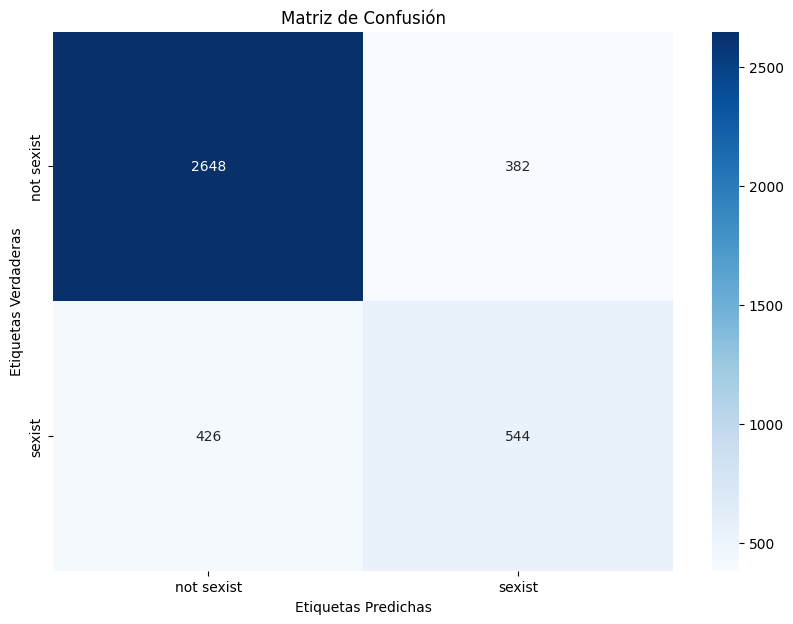

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report

# Definir el clasificador Random Forest
rf_clf = RandomForestClassifier()

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt']
}


# Realizar la búsqueda en grilla con validación cruzada
grid_search = HalvingGridSearchCV(rf_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
grid_search.fit(vectors_train, y_train_num)

# Obtener el mejor clasificador
best_rf_clf = grid_search.best_estimator_


# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = best_rf_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test_num, y_test_pred,target_names=label_names))
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 239
max_resources_: 19398
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 239
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.608) total time=   0.2s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.595) total time=   0.2s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.646) total time=   0.2s
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=1.000, test=0.646) total time=   0.5s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators

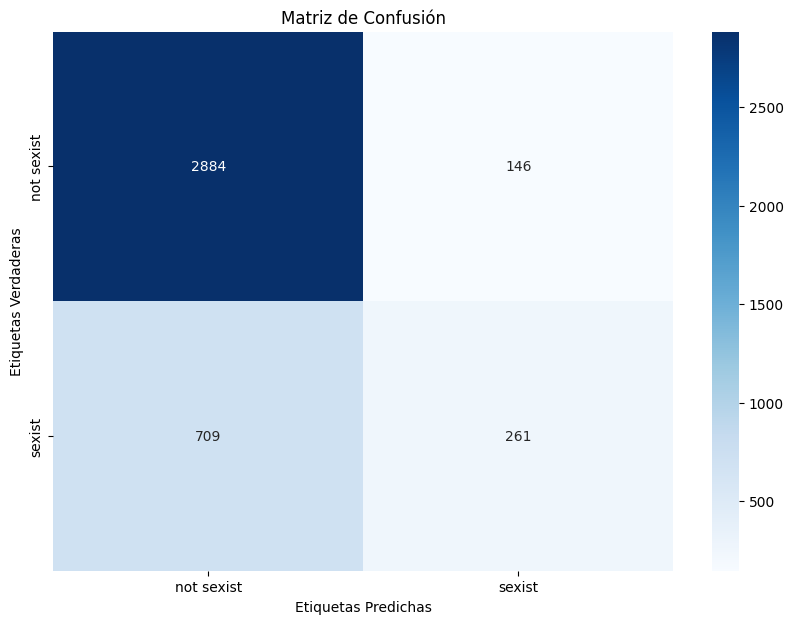

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Definir el clasificador XGBoost
#xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',objective='multi:softmax', num_class=20, random_state=42)

# Definir la grilla de parámetros para la búsqueda
param_grid = {
    'max_depth': [3, 6],#, 9],
    'learning_rate': [ 0.01],#, 0.001],
    'subsample': [0.8 ]#, 1]
}


# Realizar la búsqueda en grilla con validación cruzada
#grid_search = HalvingGridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1_micro',verbose=3)
#grid_search.fit(vectors_train, y_train_num)

# Obtener el mejor clasificador
#best_xgb_clf = grid_search.best_estimator_

xgb_clf = XGBClassifier(n_estimators=300, max_depth=9, learning_rate=0.1)

xgb_clf.fit(vectors_train, y_train_num, verbose=1)

# Evaluar el mejor clasificador en el conjunto de prueba
y_test_pred = xgb_clf.predict(vectors_test)
print('Métricas en el conjunto de prueba:')
print(classification_report(y_test_num, y_test_pred,target_names=label_names))
micro_f1 = f1_score(y_test_num, y_test_pred, average='micro')
print('Micro-F1 Score: {:.4f}'.format(micro_f1))

Métricas en el conjunto de prueba:
              precision    recall  f1-score   support

  not sexist       0.83      0.93      0.88      3030
      sexist       0.64      0.39      0.49       970

    accuracy                           0.80      4000
   macro avg       0.73      0.66      0.68      4000
weighted avg       0.78      0.80      0.78      4000

Micro-F1 Score: 0.7997


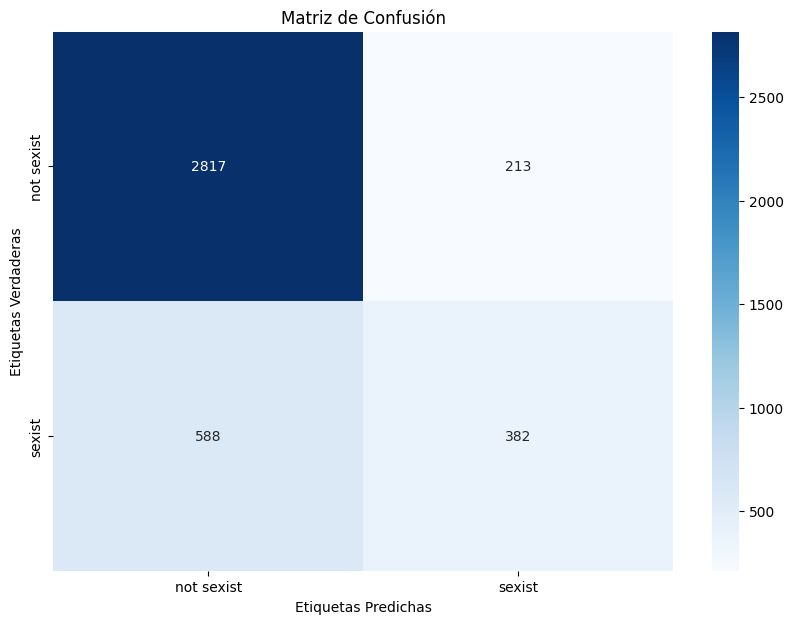

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test_num, y_test_pred)



# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# RNN

In [ ]:
import tensorflow as tf

# Suponiendo que 'word2vec_embeddings' es una matriz NumPy que contiene tus embeddings de Word2Vec
# y 'max_vocab' es el tamaño de tu vocabulario

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(3000000, 300, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20,activation='softmax')
])

model.summary()

In [ ]:
# Configurar el callback de parada temprana
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compilar el modelo con la función de pérdida y el optimizador adecuados para clasificación multiclase
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(vectors_train, y_train_num, epochs=10, validation_data=(vectors_val, y_val_num), batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/10
377/377 [==============================] - ETA: 0s - loss: 2.9941 - accuracy: 0.0547